## Get Started Object Detection

__Description__:

This notebook demonstrates how to perform object detection with DETR using HEART and MAITE

__Intended Audience__:

All T&E Users

## Contents:
1. Notebook imports and utility functions
2. Define the object detector
3. Prepare images for detection
4. Execute object detection
5. View detections
6. Execute simple evasion attack
7. Next Steps

## 1. Notebook imports

In [9]:
import requests
import numpy as np
from PIL import Image
import numpy as np
from torchvision.transforms import transforms
from heart_library.attacks.attack import JaticAttack

from maite.protocols import ObjectDetector, HasDetectionPredictions
from art.attacks.evasion import ProjectedGradientDescent

import cv2
import matplotlib
import matplotlib.pyplot as plt

plt.style.use('ggplot')
%matplotlib inline

coco_labels = [
    'N/A', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A',
    'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse',
    'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack',
    'umbrella', 'N/A', 'N/A', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis',
    'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove',
    'skateboard', 'surfboard', 'tennis racket', 'bottle', 'N/A', 'wine glass',
    'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich',
    'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake',
    'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table', 'N/A',
    'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard',
    'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A',
    'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier',
    'toothbrush'
]

def extract_predictions(predictions_, conf_thresh):
    # Get the predicted class
    predictions_class = [coco_labels[i] for i in list(predictions_["labels"])]
    #  print("\npredicted classes:", predictions_class)
    if len(predictions_class) < 1:
        return [], [], []
    # Get the predicted bounding boxes
    predictions_boxes = [[(i[0], i[1]), (i[2], i[3])] for i in list(predictions_["boxes"])]

    # Get the predicted prediction score
    predictions_score = list(predictions_["scores"])
    # print("predicted score:", predictions_score)

    # Get a list of index with score greater than threshold
    threshold = conf_thresh
    predictions_t = [predictions_score.index(x) for x in predictions_score if x > threshold]
    if len(predictions_t) > 0:
        predictions_t = predictions_t  # [-1] #indices where score over threshold
    else:
        # no predictions esxceeding threshold
        return [], [], []
    # predictions in score order
    predictions_boxes = [predictions_boxes[i] for i in predictions_t]
    predictions_class = [predictions_class[i] for i in predictions_t]
    predictions_scores = [predictions_score[i] for i in predictions_t]
    return predictions_class, predictions_boxes, predictions_scores


def plot_image_with_boxes(img, boxes, pred_cls, title):
    text_size = 2
    text_th = 2
    rect_th = 2

    for i in range(len(boxes)):
        cv2.rectangle(img, (int(boxes[i][0][0]), int(boxes[i][0][1])), (int(boxes[i][1][0]), int(boxes[i][1][1])),
                      color=(0, 255, 0), thickness=rect_th)
        # Write the prediction class
        cv2.putText(img, pred_cls[i], (int(boxes[i][0][0]), int(boxes[i][0][1])), cv2.FONT_HERSHEY_SIMPLEX, text_size,
                    (0, 255, 0), thickness=text_th)

    plt.figure()
    plt.axis("off")
    plt.title(title)
    plt.imshow(img, interpolation="nearest")
    # plt.show()

## 2. Define the object detector

In [16]:
from heart_library.estimators.object_detection.pytorch_detr import JaticPyTorchDETR
MEAN = [0.485, 0.456, 0.406]
STD = [0.229, 0.224, 0.225]
NUMBER_CHANNELS = 3
INPUT_SHAPE = (NUMBER_CHANNELS, 800, 800)

detector = JaticPyTorchDETR(device_type='cpu',
                            input_shape=INPUT_SHAPE,
                            clip_values=(0, 1), 
                            attack_losses=( "loss_ce",
                                "loss_bbox",
                                "loss_giou",),
                            labels=coco_labels,
                            channels_first=True, 
                            preprocessing=(MEAN, STD))

print('Assert that the detector is aligned with MAITE protocols:', isinstance(detector, ObjectDetector))

Using cache found in /Users/kieranfraser/.cache/torch/hub/facebookresearch_detr_main


Assert that the detector is aligned with MAITE protocols: True


## 3. Prepare images for detection

In [4]:
transform = transforms.Compose([
        transforms.Resize(INPUT_SHAPE[1], interpolation=transforms.InterpolationMode.BICUBIC),
        transforms.CenterCrop(INPUT_SHAPE[1]),
        transforms.ToTensor()
    ])

urls = ['http://images.cocodataset.org/val2017/000000039769.jpg',
'http://images.cocodataset.org/val2017/000000397133.jpg',
'http://images.cocodataset.org/val2017/000000037777.jpg',
'http://images.cocodataset.org/val2017/000000454661.jpg',
'http://images.cocodataset.org/val2017/000000094852.jpg']

coco_images = []
for url in urls:
    im = Image.open(requests.get(url, stream=True).raw)
    im = transform(im).numpy()
    coco_images.append(im)
coco_images = np.array(coco_images)

## 4. Execute Object Detection

In [5]:
output = detector(coco_images)

print('Assert that the output is aligned with MAITE protocols:', isinstance(output, HasDetectionPredictions))

Assert that the output is aligned with MAITE protocols: True


## 5. View detections

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


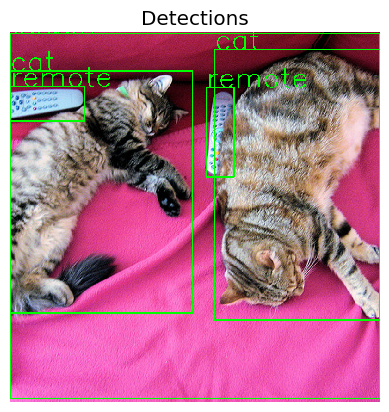

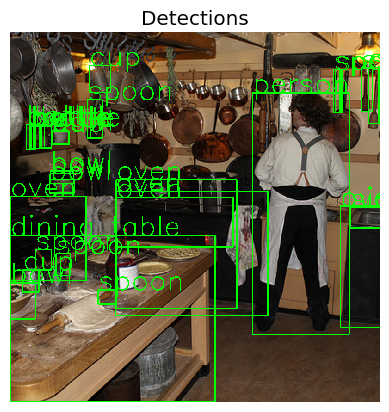

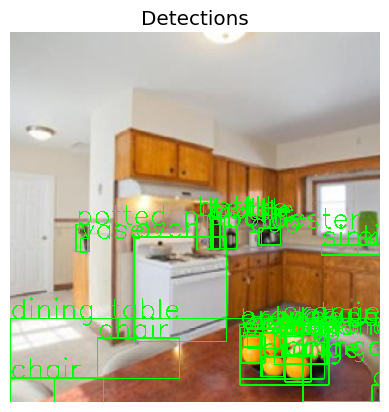

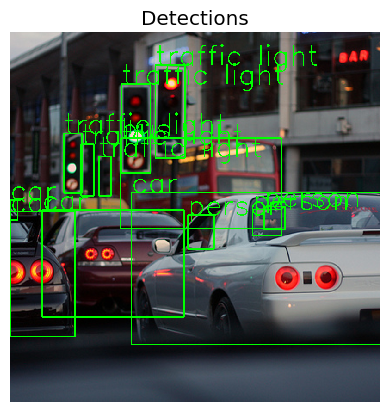

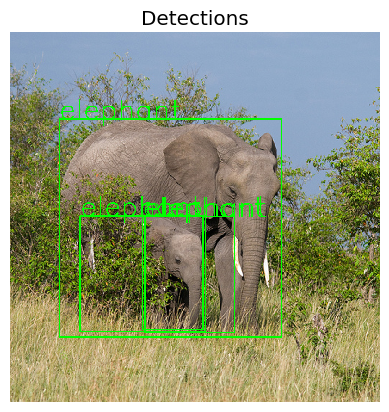

In [10]:
for i in range(len(coco_images)):
    pred = {'boxes': output.boxes[i],
            'scores': output.scores[i],
            'labels': output.labels[i]}
    preds_orig = extract_predictions(pred, 0.3)
    plot_image_with_boxes(img=coco_images[i].transpose(1,2,0).copy(), boxes=preds_orig[1], pred_cls=preds_orig[0], title="Detections")

## 6. Execute simple evasion attack

PGD - Iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


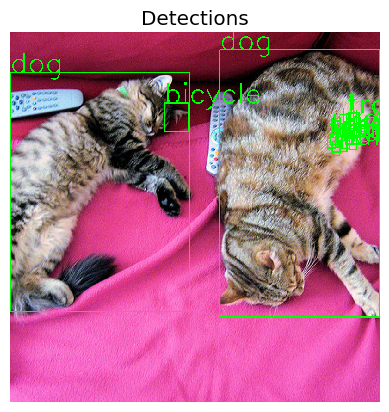

In [17]:
attack = JaticAttack(ProjectedGradientDescent(detector, max_iter=50, eps_step=0.001, eps=0.03))
output = attack.run_attack(coco_images[[0]])

adv_output = detector(output.adversarial_examples)
for i in range(len(output.adversarial_examples)): 
    pred = {'boxes': adv_output.boxes[i],
            'scores': adv_output.scores[i],
            'labels': adv_output.labels[i]}
    preds_orig = extract_predictions(pred, 0.3)
    plot_image_with_boxes(img=output.adversarial_examples[i].transpose(1,2,0).copy(), boxes=preds_orig[1], pred_cls=preds_orig[0], title="Detections")

## 7. Next Steps
- Swap in your own dataset and detect objects
- Apply additional adversarial attacks to the object detector (e.g. adversarial patches)